In [ ]:
import os

# 1. 确保 Kaggle 库已安装
!pip install -q kaggle

# 2. 检查 kaggle.json 是否上传成功
if not os.path.exists("kaggle.json"):
    print("❌ Error: The kaggle.json file was not found!")
else:
    print("✅ Found kaggle.json, configuring permissions...")
    # 创建配置目录并移动文件
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    # 3. 尝试下载数据
    print("Downloading data from Kaggle...")
    !kaggle datasets download -d abdelghaniaaba/wildfire-prediction-dataset

    # 4. 再次检查是否下载成功
    if os.path.exists("wildfire-prediction-dataset.zip"):
        print("✅ 下载成功！开始解压...")
        import zipfile
        with zipfile.ZipFile("wildfire-prediction-dataset.zip", 'r') as zip_ref:
            zip_ref.extractall("./data")
        print("🎉 Unzipping completed! The data has been saved in the ./data folder.")
    else:
        print("❌ Download failed. Please check the red error message above.")

✅ Found kaggle.json, configuring permissions...
Dataset URL: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset
License(s): other
100% 1.45G/1.45G [00:22<00:00, 261MB/s]
100% 1.45G/1.45G [00:22<00:00, 69.5MB/s]
✅ 下载成功！开始解压...
🎉 Unzipping completed! The data has been saved in the ./data folder.


./data The contents of the folder: ['train', 'valid', 'test']
Number of training sets: {'wildfire': 15750, 'nowildfire': 14500}
Number of test sets: {'wildfire': 3480, 'nowildfire': 2820}
Number of validation sets: {'wildfire': 3480, 'nowildfire': 2820}


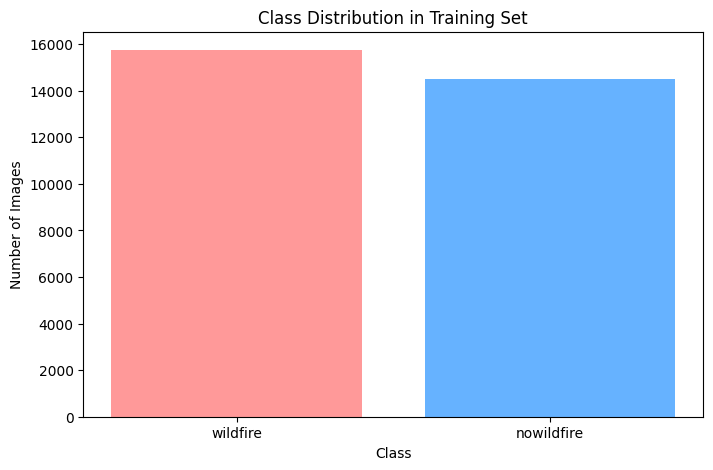

Display samples of 'wildfire' (with fire):


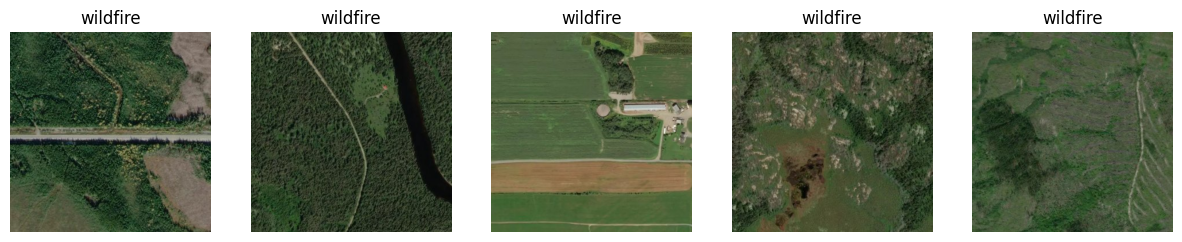

Display the 'nowildfire' sample:


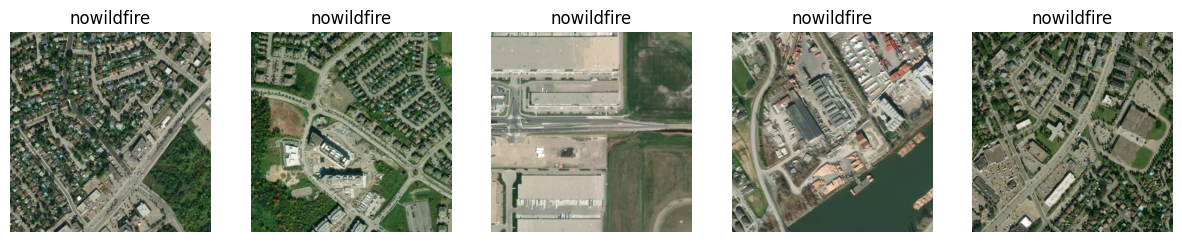

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random

# 1. 定义数据路径
base_dir = './data'

# 检查一下解压后的文件夹名字，防止路径不对
print("./data The contents of the folder:", os.listdir(base_dir))

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
valid_dir = os.path.join(base_dir, 'valid')

# 2. 统计各类别图片的数量
def count_images(directory):
    counts = {}
    if os.path.exists(directory):
        for class_name in os.listdir(directory):
            class_path = os.path.join(directory, class_name)
            if os.path.isdir(class_path):
                counts[class_name] = len(os.listdir(class_path))
    return counts

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)
valid_counts = count_images(valid_dir)

print(f"Number of training sets: {train_counts}")
print(f"Number of test sets: {test_counts}")
print(f"Number of validation sets: {valid_counts}")

# 3. 绘制数据分布图 (PPT素材 1)
plt.figure(figsize=(8, 5))
plt.bar(train_counts.keys(), train_counts.values(), color=['#FF9999', '#66B2FF'])
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

# 4. 展示样本图片 (PPT素材 2)
# 随机抽取 Wildfire 和 NoWildfire 各 5 张
def show_samples(directory, class_name, num_samples=5):
    class_path = os.path.join(directory, class_name)
    image_files = os.listdir(class_path)
    samples = random.sample(image_files, num_samples)

    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(samples):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

print("Display samples of 'wildfire' (with fire):")
show_samples(train_dir, 'wildfire')

print("Display the 'nowildfire' sample:")
show_samples(train_dir, 'nowildfire')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time
import os
import copy
from PIL import ImageFile # Import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True # Allow loading of truncated images

# 1. 设置设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. 数据预处理 (Data Augmentation)
# 这一步让模型学会从不同角度识别图片
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),      # ResNet标准输入大小
        transforms.RandomHorizontalFlip(),  # 随机水平翻转 (数据增强)
        transforms.RandomRotation(10),      # 随机旋转 (数据增强)
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 标准化
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 3. 加载数据
data_dir = './data' # 数据路径
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}

# 这里的 batch_size 设置为 32，如果显存不够可以改小
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
              for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# 输出数据集信息
print(f"Classes: {class_names}")
print(f"Training set size: {dataset_sizes['train']}")
print(f"Test set size: {dataset_sizes['test']}")

# 4. 定义训练函数
def train_model(model, criterion, optimizer, num_epochs=3):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # 记录损失和准确率用于画图
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # 每个epoch都有训练和验证阶段
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # 训练模式
            else:
                model.eval()   # 评估模式

            running_loss = 0.0
            running_corrects = 0

            # 遍历数据
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # 前向传播
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 反向传播 + 优化 (只在训练阶段)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计数据
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            # 输出每轮结果
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 深度拷贝模型 (保存最好的那个)
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model, history

# 5. 初始化 ResNet18 模型
# weights='DEFAULT' 表示使用预训练的权重 (Transfer Learning)
model_ft = models.resnet18(weights='DEFAULT')

# 修改最后一层 (全连接层)，因为我们要分2类 (wildfire vs nowildfire)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
# 学习率设为 0.001
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 6. 开始训练！
print("🚀 Starting model training...")
model_ft, history = train_model(model_ft, criterion, optimizer_ft, num_epochs=3)

# 7. 保存模型
torch.save(model_ft.state_dict(), 'wildfire_model.pth')
print("✅ Model saved as wildfire_model.pth")

Using device: cuda:0
Classes: ['nowildfire', 'wildfire']
Training set size: 30250
Test set size: 6300
🚀 Starting model training...
Epoch 1/3
----------
train Loss: 0.1148 Acc: 0.9559
test Loss: 0.0426 Acc: 0.9860

Epoch 2/3
----------
train Loss: 0.0573 Acc: 0.9801
test Loss: 0.0273 Acc: 0.9898

Epoch 3/3
----------
train Loss: 0.0416 Acc: 0.9846
test Loss: 0.0232 Acc: 0.9935

Training complete in 7m 25s
Best val Acc: 0.993492
✅ Model saved as wildfire_model.pth


Calculating the confusion matrix, please wait...

Classification Report:
              precision    recall  f1-score   support

  nowildfire       0.99      0.99      0.99      2820
    wildfire       1.00      0.99      0.99      3480

    accuracy                           0.99      6300
   macro avg       0.99      0.99      0.99      6300
weighted avg       0.99      0.99      0.99      6300



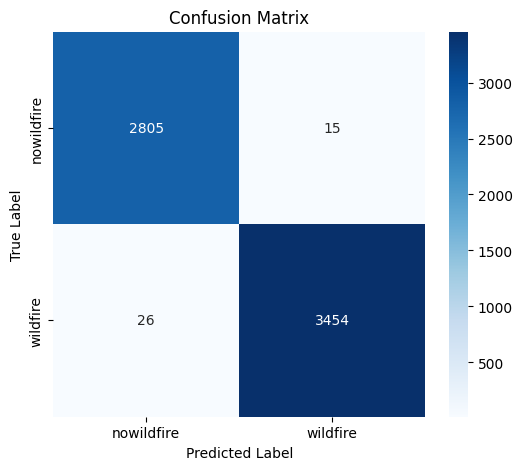

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 1. 设为评估模式
model_ft.eval()

# 2. 获取所有测试集的预测结果
y_true = []
y_pred = []

print("Calculating the confusion matrix, please wait...")

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 3. 生成分类报告 (包含 Precision, Recall, F1-Score)
# PPT里可以直接引用这些数字
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 4. 绘制混淆矩阵
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# 1. 安装 Gradio
!pip install -q gradio

import gradio as gr
import torch.nn.functional as F

# 2. 定义预测函数
def predict_image(image):
    # 预处理图片
    image_tensor = data_transforms['test'](image).unsqueeze(0).to(device)

    # 模型推理
    model_ft.eval()
    with torch.no_grad():
        outputs = model_ft(image_tensor)
        # 使用 Softmax 获取概率
        probs = F.softmax(outputs, dim=1)

    # 返回结果字典 {类别: 概率}
    return {class_names[i]: float(probs[0][i]) for i in range(2)}

# 3. 创建 Gradio 界面
iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil", label="Upload Satellite Image"),
    outputs=gr.Label(num_top_classes=2, label="Prediction Result"),
    title="🛰️ AI Wildfire Detection System (SDG 13)",
    description="Upload a satellite image to detect if there is a wildfire. This aligns with SDG 13: Climate Action.",
    examples=[
        # 这里可以使用刚才看到的示例图片路径，方便演示时点击
        [os.path.join(test_dir, 'wildfire', os.listdir(os.path.join(test_dir, 'wildfire'))[0])],
        [os.path.join(test_dir, 'nowildfire', os.listdir(os.path.join(test_dir, 'nowildfire'))[0])]
    ]
)

# 4. 启动！
print("The webpage is starting. Please click the link below ....")
iface.launch(share=True, debug=True)

The webpage is starting. Please click the link below ....
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://357b5fa062c6c83e58.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Created dataset file at: .gradio/flagged/dataset1.csv
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://357b5fa062c6c83e58.gradio.live
